### **Calculate elevation change by the generated aster dems.**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff
from utils.lay_stack import lay_stack
from pprint import pprint


### **1. Check the elevation changes.**

In [3]:
### Multitemporal dems data
tile_lat, tile_lon = '30', '95'
years = ['2006','2007','2008', '2009', '2018','2019','2020','2021']
path_dems = ['data/aster-stereo/SETP-%s/tiles-dem/tile-%s-%s/dems_mosaic_subs.tif' % (year, tile_lat, tile_lon) for year in years]
path_nodata = 'data/aster-stereo/tiles-nodata/tile_%s_%s.tif' % (tile_lat, tile_lon) 
path_dems = [ path_dem if os.path.exists(path_dem) else path_nodata for path_dem in path_dems ]
### Auxilary data
path_srtm = 'data/dem-data/srtm-c/tiles/tile_%s_%s.tif' % (tile_lat, tile_lon)
path_glacier='data/rgi60/tiles/tile_%s_%s.tif' % (tile_lat, tile_lon)
### merge into one paths list
paths_img = [path_srtm] + path_dems + [path_glacier]
paths_img


['data/dem-data/srtm-c/tiles/tile_30_95.tif',
 'data/aster-stereo/SETP-2006/tiles-dem/tile-30-95/dems_mosaic_subs.tif',
 'data/aster-stereo/SETP-2007/tiles-dem/tile-30-95/dems_mosaic_subs.tif',
 'data/aster-stereo/SETP-2008/tiles-dem/tile-30-95/dems_mosaic_subs.tif',
 'data/aster-stereo/SETP-2009/tiles-dem/tile-30-95/dems_mosaic_subs.tif',
 'data/aster-stereo/SETP-2018/tiles-dem/tile-30-95/dems_mosaic_subs.tif',
 'data/aster-stereo/SETP-2019/tiles-dem/tile-30-95/dems_mosaic_subs.tif',
 'data/aster-stereo/SETP-2020/tiles-dem/tile-30-95/dems_mosaic_subs.tif',
 'data/aster-stereo/SETP-2021/tiles-dem/tile-30-95/dems_mosaic_subs.tif',
 'data/rgi60/tiles/tile_30_95.tif']

Images layer stacking done.
number of the dems:  8


Text(0.5, 1.0, 'glacier_rgi60')

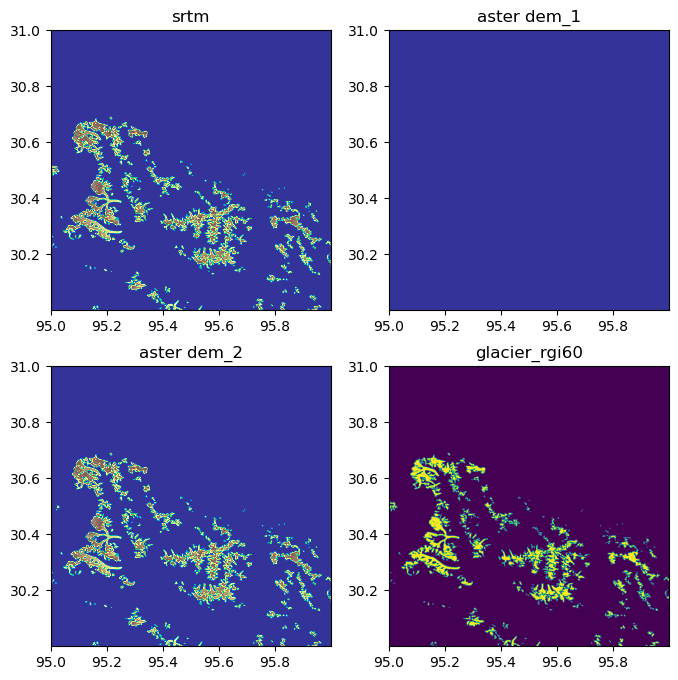

In [4]:
lay_stack(path_imgs=paths_img, path_out='dems_laysta.tif', extent_mode='union', res=None)
dems, dems_info = readTiff('dems_laysta.tif')
num_dems = dems.shape[-1]-2
print('number of the dems: ', num_dems)
## Mask the nodata dem region and the non-glacier region.
glacier_mask_3d = np.broadcast_to(dems[:,:,-1:], (dems.shape[0], dems.shape[1], dems.shape[2]))
dems = np.ma.masked_where(np.logical_or(glacier_mask_3d == 0, dems == 0), dems) 
### check the layer stacked image. 
plt.figure(figsize=(8,8))
plt.subplot(2,2,1); plt.imshow(dems[:,:,0].filled(0), vmax=7000, vmin=1, extent=dems_info['geoextent'], cmap='terrain'); plt.title('srtm')
plt.subplot(2,2,2); plt.imshow(dems[:,:,1].filled(0), vmax=7000, vmin=1, extent=dems_info['geoextent'], cmap='terrain'); plt.title('aster dem_1')
plt.subplot(2,2,3); plt.imshow(dems[:,:,2].filled(0), vmax=7000, vmin=1, extent=dems_info['geoextent'], cmap='terrain'); plt.title('aster dem_2')
plt.subplot(2,2,4); plt.imshow(dems[:,:,-1].filled(0), extent=dems_info['geoextent']); plt.title('glacier_rgi60')


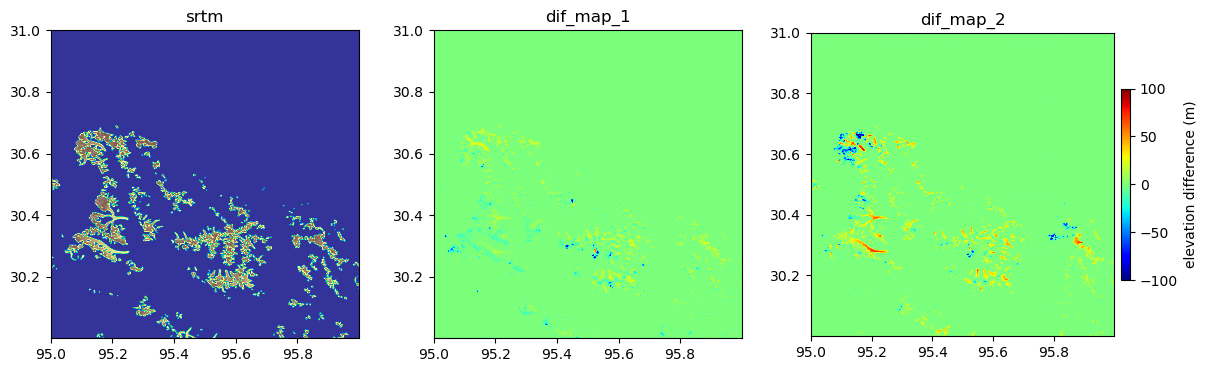

In [5]:
### check the dems difference map
dem_dif_1 = dems[:,:,0]-dems[:,:,2]
dem_dif_2 = dems[:,:,0]-dems[:,:,-2]
plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.imshow(dems[:,:,0].filled(0), vmax=7000, vmin=0, extent=dems_info['geoextent'], cmap='terrain');plt.title('srtm')
plt.subplot(1,3,2); plt.imshow(dem_dif_1.filled(0), vmax=100, vmin=-100, extent=dems_info['geoextent'], cmap='jet');plt.title('dif_map_1')
plt.subplot(1,3,3); plt.imshow(dem_dif_2.filled(0), vmax=100, vmin=-100, extent=dems_info['geoextent'], cmap='jet');plt.title('dif_map_2')
cb = plt.colorbar(fraction=0.03, pad=0.02)
cb.set_label('elevation difference (m)')



### **2. Multi-temporal elevation changes of one tile**

In [6]:
dems_dif_map = np.zeros_like(dems.data[:,:,0:num_dems])
for i in range(num_dems):
  dems_dif_map[:,:,i] = dems[:,:,0]-dems[:,:,i+1]  # calculate dems diffference.
  dems_dif_map[:,:,i] = np.where(dems.mask[:,:,i+1] == True, -999, dems_dif_map[:,:,i])  ## mask the non-dem and non-glacier region.
dems_dif_map = np.ma.masked_where(np.logical_or(dems_dif_map==-999, abs(dems_dif_map)>150), dems_dif_map)
dems_dif_map.shape



(3600, 3600, 8)

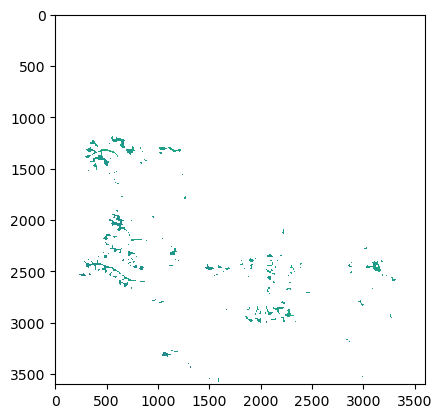

In [7]:
plt.imshow(dems_dif_map[:,:,1])


### Filter out the outliers

In [37]:
dems_dif_filter = dems_dif_map.copy()
## Filter out outliers (lower than mean - 3*sigma, or larger than mean - 3*sigma).
for i_dem in range(dems_dif_map.shape[-1]):
# for i_dem in range(0,1):
  num_valid = (~dems_dif_filter[:,:,i_dem].mask).sum()   ### number of the valid points
  print('Number of valid dem change pixel: ', num_valid)
  if num_valid < 200:
    dems_dif_filter[:,:,i_dem] = np.ma.masked_all(dems_dif_filter[:,:,i_dem].shape)
  else:
    dif_mean, dif_sigma = np.mean(dems_dif_filter), np.std(dems_dif_filter)
    thre_max, thre_min = dif_mean + 3*dif_sigma, dif_mean - 3*dif_sigma
    dems_dif_filter[:,:,i_dem] = np.ma.masked_where(np.logical_or(dems_dif_filter[:,:,i_dem]>thre_max, dems_dif_filter[:,:,i_dem]<thre_min), dems_dif_filter[:,:,i_dem])  
  num_filter = (~dems_dif_filter[:,:,i_dem].mask).sum()   ### number of the filtered points
  print('Number of filtered dem change pixel: ', num_filter)
  if num_filter < 200:
    dems_dif_filter[:,:,i_dem] = np.ma.masked_all(dems_dif_filter[:,:,i_dem].shape)



Number of valid dem change pixel:  0
Number of filtered dem change pixel:  0


In [38]:
for i_dem in range(dems_dif_filter.shape[-1]):
  print('mean:', np.mean(dems_dif_map[:,:,i_dem]), ' sigma: ', np.std(dems_dif_map[:,:,i_dem]))


mean: --  sigma:  --
mean: 1.226287535393554  sigma:  18.198585144327826
mean: -0.1434465333750557  sigma:  23.624635506264887
mean: --  sigma:  --
mean: 6.757609285699283  sigma:  32.619303630424646
mean: -1.2269628803151926  sigma:  45.484298679604464
mean: 0.6265124904320183  sigma:  39.86878733216298
mean: 9.825166245579307  sigma:  30.21226159203076


#### Plot the histogram.

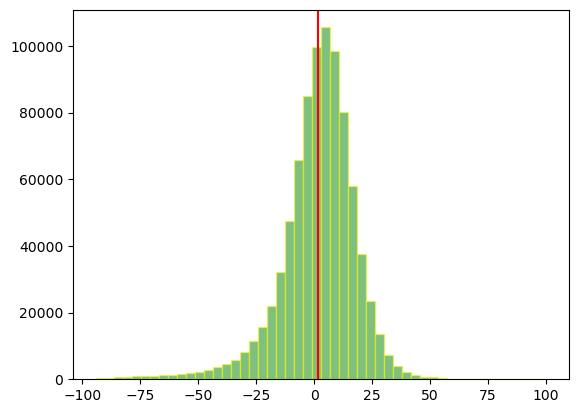

In [30]:
i_dem = 1
id_valid = np.where(dems_dif_filter[:,:,i_dem].mask == False)
n, bins, patches = plt.hist(dems_dif_filter[:,:,i_dem][id_valid], bins=50, lw=1, ec="yellow", fc="green", alpha=0.5)
plt.axvline(x = np.mean(dems_dif_filter[:,:,i_dem]), color = 'r', label = 'axvline - full height')
